In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, nquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
from  scipy.interpolate import interp1d
from scipy.misc import derivative
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import glob
from unsio import *
import os
import wkbl
from wkbl.astro.halo_info import *
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import datetime
from scipy.misc import derivative
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
msuntokg = 1.99844e30
kgtoGeVc2 = 1./1.782662e-27
kpctocm = 3.08567758e21
denstoGeVcm3 =  msuntokg * kgtoGeVc2 / kpctocm**3

In [3]:
colors = np.array(["#7fb3d5","#5499c7","#2980b9","#2471a3","#1f618d","#1f618d","#154360",
                   "#4a235a","#5b2c6f","#6c3483","#7d3c98","#8e44ad","#a569bd","#bb8fce"
                  ])

In [4]:
### General block ###
# general variables 
hydro = wkbl.astro.halo_info.MochimaHydro()
dmo = wkbl.astro.halo_info.Mochimadmo()

In [29]:
##### LOAD And CENTER ####
simname=hydro.name
myhydro = wkbl.Galaxy_Hound(hydro.path)
# uncomment to calculate the dens center of stars
#ok,rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32), myhydro.st.mass)
#centro_rho = myhydro.st.pos3d[np.where(rho == rho.max())][0]
#centro_rho
#sys.exit()
#print myhydro.dm.pos3d[:,0].max()
myhydro.center_shift(hydro.c_rho_st)
myhydro.r_virial(600,n=2)

loading Dark matter..
loading Stars..
loading Gas..
| r_200 = 212.70
| Diagonal matrix computed 
|    | 20, 0, 0|
| D =| 0, 14, 0|
|    | 0,  0, 4|


In [30]:
pos_array = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
ok,myhydro.dm.rho,_= CF.getDensity(pos_array, myhydro.dm.mass)

In [54]:
rmin, rmax, deltaz = 7.5, 8.5, 1.2
selection = (myhydro.dm.r>rmin)&(myhydro.dm.r<rmax)
arr = myhydro.dm.rho[selection]
Bins = np.linspace(arr.min(),arr.max(),30)
hist, bins = np.histogram(myhydro.dm.rho[selection],bins=Bins,normed=0)
n_tot = float(len(myhydro.dm.rho[selection]))
width = bins[1]-bins[0]
mean = np.mean(myhydro.dm.rho[selection])
selection = (myhydro.dm.R>rmin)&(myhydro.dm.R<rmax)&(np.abs(myhydro.dm.pos3d[:,2])<deltaz)
histD, binsD = np.histogram(myhydro.dm.rho[selection],bins=Bins,normed=0)
n_totD = float(len(myhydro.dm.rho[selection]))
widthD = bins[1]-bins[0]
meanD = np.mean(myhydro.dm.rho[selection])


In [55]:
print np.sum(hist/n_tot), n_tot
print np.sum(histD/n_tot), n_totD

1.0 4998.0
0.18147258903561425 907.0


<IPython.core.display.Javascript object>


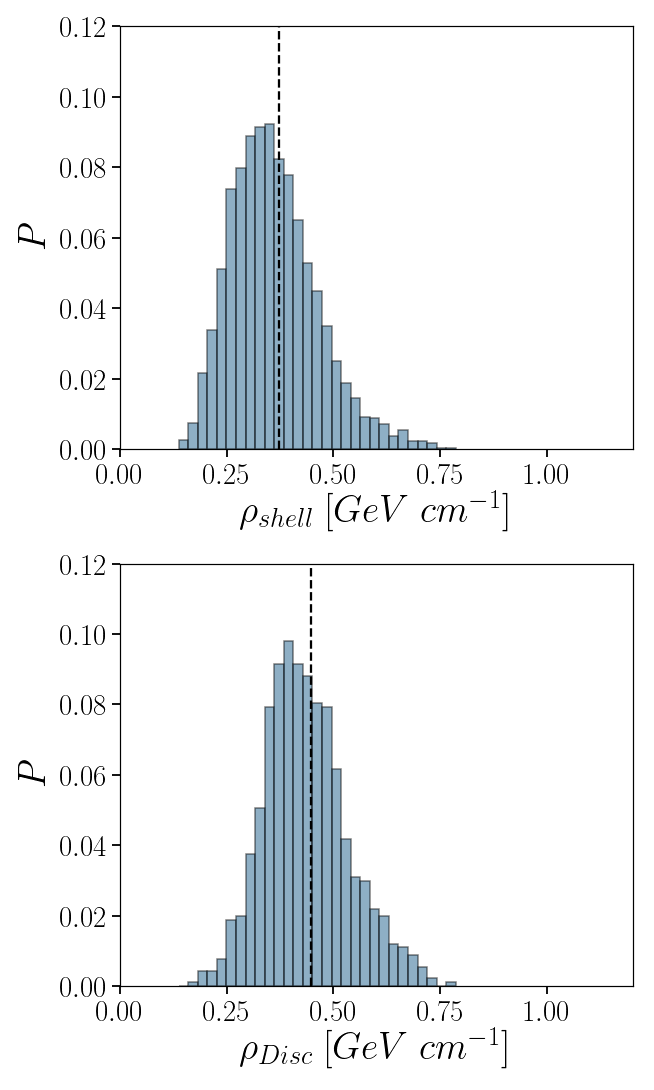

In [58]:
fig, [ax,ax1] = plt.subplots(2,1,figsize=[6,10])
ax.set_ylim([0,0.12])
ax.set_xlim([0,1.2])
fonto=25
ax.set_xlabel(r"$\rho_{shell}\;[GeV\;cm^{-1}]$",fontsize=fonto )
ax.set_ylabel(r"$P$",fontsize=fonto )
ax.bar(Bins[:-1]*denstoGeVcm3,hist/n_tot,color=colors[4],width=width*denstoGeVcm3,edgecolor='k',alpha=0.5)
ax.axvline(x=mean*denstoGeVcm3,c='k',ls='--')
ax.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)

ax1.set_ylim([0,0.12])
ax1.set_xlim([0,1.2])
ax1.set_xlabel(r"$\rho_{Disc}\;[GeV\;cm^{-1}]$",fontsize=fonto )
ax1.set_ylabel(r"$P$",fontsize=fonto )
ax1.bar(Bins[:-1]*denstoGeVcm3,histD/n_totD,color=colors[4],width=width*denstoGeVcm3,edgecolor='k',alpha=0.5)
ax1.axvline(x=meanD*denstoGeVcm3,c='k',ls='--')
ax1.tick_params(axis='both', which='major', labelsize=19, size=5,width=1.2)

plt.tight_layout()

In [34]:
myhydro.dm.Rxz = np.sqrt((myhydro.dm.pos3d[:,0]**2)+(myhydro.dm.pos3d[:,2]**2))
myhydro.dm.Ryz = np.sqrt((myhydro.dm.pos3d[:,1]**2)+(myhydro.dm.pos3d[:,2]**2))

In [35]:
deltaz = 1
z_cen = np.linspace(-15,15,30)
discxy =  discxz = discyz = np.array([])
for i in z_cen:
    selection = (myhydro.dm.R>rmin)&(myhydro.dm.R<rmax)&(np.abs(myhydro.dm.pos3d[:,2]-i)<deltaz)
    discxy = np.append(discxy,np.mean(myhydro.dm.rho[selection])*denstoGeVcm3)
    selection = (myhydro.dm.Rxz>rmin)&(myhydro.dm.Rxz<rmax)&(np.abs(myhydro.dm.pos3d[:,1]-i)<deltaz)
    discxz = np.append(discxz,np.mean(myhydro.dm.rho[selection])*denstoGeVcm3)
    selection = (myhydro.dm.Ryz>rmin)&(myhydro.dm.Ryz<rmax)&(np.abs(myhydro.dm.pos3d[:,0]-i)<deltaz)
    discyz = np.append(discyz,np.mean(myhydro.dm.rho[selection])*denstoGeVcm3)

<IPython.core.display.Javascript object>


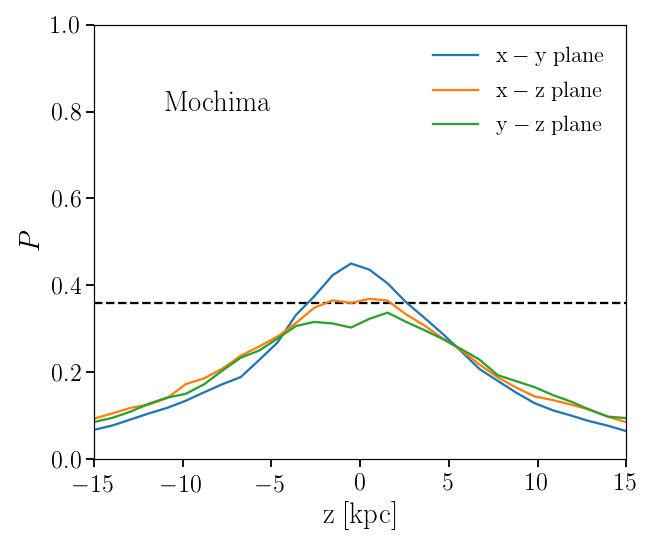

In [36]:
fig, ax = plt.subplots(figsize=[6,5])
fonto=19
ax.set_xlabel(r"$\rm z\;[kpc]$",fontsize=fonto )
ax.set_ylabel(r"$P$",fontsize=fonto )
ax.set_ylim([0,1])
ax.set_xlim([-15,15])

ax.axhline(y=0.36,c='k',ls='--')
ax.plot(z_cen, discxy,label=r"$\rm x-y\;plane$")
ax.plot(z_cen, discxz,label=r"$\rm x-z\;plane$")
ax.plot(z_cen, discyz,label=r"$\rm y-z\;plane$")
ax.tick_params(axis='both', which='major', labelsize=16, size=5,width=1.2)
ax.text(-11,0.8,r"$\rm "+ hydro.namenospace+"$",fontsize=fonto)
plt.tight_layout()
leg = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=15)
leg.get_frame().set_linewidth(0.0)


In [37]:
deltaz = 1
r_cen = np.linspace(0.5,50,50)
ratioxy =  ratioxz = ratioyz = np.array([])
thick = 0.5
for i in r_cen:
    selectionshell = (myhydro.dm.r>i-thick)&(myhydro.dm.r<i+thick)
    meanS = np.mean(myhydro.dm.rho[selectionshell])
    selection = (myhydro.dm.R>i-thick)&(myhydro.dm.R<i+thick)&(np.abs(myhydro.dm.pos3d[:,2])<deltaz)
    ratioxy = np.append(ratioxy,np.mean(myhydro.dm.rho[selection])/meanS)
    selection = (myhydro.dm.Rxz>i-thick)&(myhydro.dm.Rxz<i+thick)&(np.abs(myhydro.dm.pos3d[:,1])<deltaz)
    ratioxz = np.append(ratioxz,np.mean(myhydro.dm.rho[selection])/meanS)
    selection = (myhydro.dm.Ryz>i-thick)&(myhydro.dm.Ryz<i+thick)&(np.abs(myhydro.dm.pos3d[:,0])<deltaz)
    ratioyz = np.append(ratioyz,np.mean(myhydro.dm.rho[selection])/meanS)

<IPython.core.display.Javascript object>


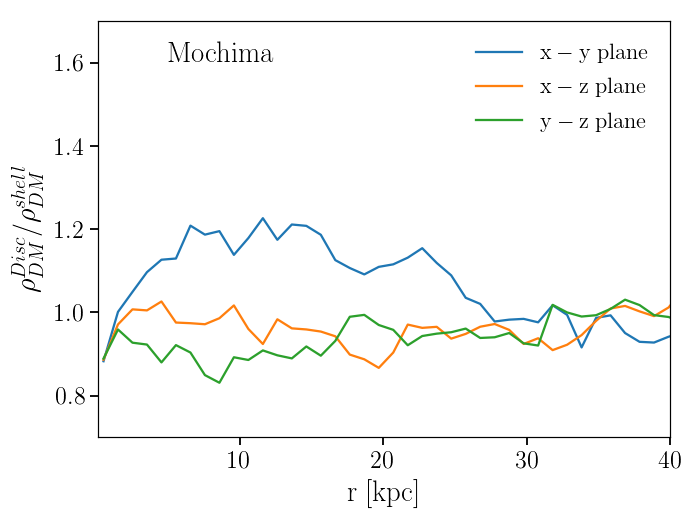

In [38]:
fig, ax = plt.subplots()
fonto=19
ax.set_xlabel(r"$\rm r\;[kpc]$",fontsize=fonto )
ax.set_ylabel(r"$\rho_{DM}^{Disc}/\rho_{DM}^{shell}$",fontsize=fonto )
ax.set_ylim([0.7,1.7])
ax.set_xlim([0.1,40])

ax.plot(r_cen,ratioxy,label=r"$\rm x-y\;plane$")
ax.plot(r_cen,ratioxz,label=r"$\rm x-z\;plane$")
ax.plot(r_cen,ratioyz,label=r"$\rm y-z\;plane$")

ax.text(5,1.6,r"$\rm "+ hydro.namenospace+"$",fontsize=fonto)

ax.tick_params(axis='both', which='major', labelsize=16, size=5,width=1.2)
leg = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=15)
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()

In [39]:
print 0.023*(1000**3)*denstoGeVcm3, 0.012*(1000**3)*denstoGeVcm3

0.877603421597 0.457880046051


In [62]:
pos_dm = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhydro.gs.pos3d.reshape(len(myhydro.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
phi_cord = np.concatenate((myhydro.dm.phi,myhydro.st.phi, myhydro.gs.phi))

mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
v = np.concatenate((myhydro.dm.v,myhydro.st.v,myhydro.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

9869970 9869970


In [66]:
limmin, limmax = 7.5,8.5
enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
vc = np.sqrt(myhydro.p.G * enclosed_m / ((limmin + limmax) /2. )) * myhydro.p.kpctokm
print vc/np.sqrt(2.)

184.31639401767941


In [67]:
hydro.v_esc_sph[1]

552.56